# Movie Review Classification Using State-of-the-art NLP Model BERT 

## First: Installing and importing our pre-requisite libraries

1. __transformers__: This library is used to utilize the state-of-the-art NLP model BERT
2. __pandas__: This utility library is used to manipulate data efficiently and effectively
3. __tqdm__: This library is used to track the progress of any ongoing iterable process
4. __nltk__: This library is used to pre-process data before giving them to the NLP model
5. __torch__: Pytorch library, used to create and manage neural networks

To install pytorch on a CUDA-capable machine, run this command in the terminal:
```bash
pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
```

In [ ]:
%pip install transformers
%pip install pandas
%pip install tqdm
%pip install nltk
%pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 33.6 MB/s 
     |████████████████████████████████| 7.6 MB 60.4 MB/s 
     |████████████████████████████████| 182 kB 83.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=cff561da656f00d1500538aee760b080f72fc758c911208bc1b4d882043f9658
  Stored in directory: /root/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [ ]:
from transformers import BertTokenizer
from transformers import BertModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import torch
from torch import nn
from torch.optim import Adam
# import splitfolders
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import os
import glob



## Text Pre-Processing

First, we pre-process our dataset to prepare it for training our model effectively.

### Splitting the folders

In [ ]:
splitfolders.ratio("data/balanced", output="data/splits", seed=2022, ratio=(.7, .1, .2), group_prefix=None, move=False)

### Cleaning strings in text files

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
path="data/processed/train/pos"
def lemmatize(path):
    files = glob.glob(path)
    df = pd.DataFrame(columns=['text', 'class'])
    for file in files:
        with open(file,encoding="utf8") as f:
            text = f.read()
            text = text.lower()
            text = text.translate(str.maketrans('', '', string.punctuation))
            text = text.split()
            text = [lemmatizer.lemmatize(word) for word in text if not word in stop_words]
            text = ' '.join(text)
            df = df.append({'text': text, 'class': "+"}, ignore_index=True)
    return df

df = lemmatize(path + "/*.txt")
df.to_csv(path + "/pos_labled.csv", index=False)

### combining processed csvs

In [ ]:
df1 = pd.read_csv("data/processed/test/test-neg.csv")
df2 = pd.read_csv("data/processed/test/test-pos.csv")
df = pd.concat([df1, df2], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv("data/processed/test/test.csv", index=False)

### merging data split files


In [ ]:

path="data/splits/val/neg"
def collect(path):
    files = glob.glob(path)
    df = pd.DataFrame(columns=['text', 'class'])
    for file in files:
        with open(file,encoding="utf8") as f:
            text = f.read()
            df = df.append({'text': text, 'class': "-"}, ignore_index=True)
    return df
df = collect(path + "/*.txt")
df.to_csv(path + "/val-neg.csv", index=False)

### combining unprocessed csvs

In [ ]:
df1 = pd.read_csv("data/splits/val/val-neg.csv")
df2 = pd.read_csv("data/splits/val/val-pos.csv")
df = pd.concat([df1, df2], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv("data/splits/val/val.csv", index=False)

## Reading from the CSVs

Now we need to read our processed and unprocessed CSVs into corresponding dataframes using pandas.

The reason we read in unprocessed data as well is, we are going to train once with processed and another with unprocessed data and check to see the difference in model competence

In [ ]:
# Read-in the processed data
df_train_proc = pd.read_csv("data/processed/train/train.csv")
df_val_proc = pd.read_csv("data/processed/val/val.csv")
df_test_proc = pd.read_csv("data/processed/test/test.csv")

# Read-in the unprocessed data
df_train_raw = pd.read_csv("data/splits/train/s-train.csv")
df_val_raw = pd.read_csv("data/splits/val/s-val.csv")
df_test_raw = pd.read_csv("data/splits/test/s-test.csv")

## Creating classes we're going to work with

### Identify global variables we're going to work with

- _tokenizer_: BertTokenizer object used to convert text into tokens for BERT to work with
- _label_ids_: Dictionary for each label with a corresponding numeric ID

In [ ]:
tokenizer = BertTokenizer.from_pretrained( 'bert-base-cased' )
label_ids = {'-' : 0, '+' : 1}

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### First: Dataset class to hold our data

This class will contain lists of processed model-ready data. Note that processing here is different from text pre-processing we've done earlier. This one relates to tokenization and label IDing.

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [label_ids[verdict] for verdict in df['class']]
        self.texts = [tokenizer(text, padding='max_length', max_length = 512, truncation=True, 
                                    return_tensors="pt") for text in tqdm( iterable=df['text'], desc='Tokenizing' )]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    # Fetch a batch of labels
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    # Fetch a batch of inputs
    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

### Second: NeuralNetwork class to hold our model

#### <u>Description of our neural network</u>:
- The network's input layer takes in 768 inputs corresponding to the vector provided by BERT's pooled output (classification output)
- Our network consists of 4 hidden layers with 512, 256, 128, 64 units respectively.
- The output layer gives sigmoid function to classify the input vector

#### <u>Structure of every layer</u>:
Every layer in our neural network consists of three sublayers. Here they are in order:
1. __Dropout Layer__: This layer zeros out some parameters passing through it by a given probability. This is useful for avoiding overfitting. Said probability is given through the 'dropout_probability' argument in the constructor.
2. __Linear Layer__: This layer contains all of our main computation neurons which give us linear functions for fitting the model.
3. __Activation Layer__: This layer is responsible for applying activation function and converting the linear outputs into non-linear, cascadable outputs.

In [ ]:
class NeuralNetwork(nn.Module):

    def __init__(self, dropout_probability=0.4):
        super(NeuralNetwork, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')

        self.network = []

        # Input Layer to Hidden layer 1
        self.dropout1 = nn.Dropout( 0.0 )
        self.linear1 = nn.Linear( 768, 512 )
        self.relu1 = nn.ReLU( self.linear1 )
        self.network.append( [self.dropout1, self.linear1, self.relu1] ) 

        # Hidden layer 1 to Hidden layer 2
        self.dropout2 = nn.Dropout( dropout_probability )
        self.linear2 = nn.Linear( 512, 256 )
        self.relu2 = nn.ReLU( self.linear2 )
        self.network.append( [self.dropout2, self.linear2, self.relu2] )
        
        # Hidden layer 2 to Hidden layer 3
        self.dropout3 = nn.Dropout( dropout_probability )
        self.linear3 = nn.Linear( 256, 128 )
        self.relu3 = nn.ReLU( self.linear3 )
        self.network.append( [self.dropout3, self.linear3, self.relu3] )

        # Hidden layer 3 to Hidden layer 4
        self.dropout4 = nn.Dropout( dropout_probability )
        self.linear4 = nn.Linear( 128, 64 )
        self.relu4 = nn.ReLU( self.linear4 )
        self.network.append( [self.dropout4, self.linear4, self.relu4] )

        # Hidden Layer 4 to Output
        self.dropout5 = nn.Dropout( dropout_probability )
        self.linear5 = nn.Linear( 64, 2 )
        self.relu5 = nn.ReLU( self.linear5 )
        self.network.append( [self.dropout5, self.linear5, self.relu5] )

        # Output Layer
        self.dropout6 = nn.Dropout( 0.0 )
        self.linear6 = nn.Linear( 2, 1 )
        self.output_layer = nn.Sigmoid()
        self.network.append( [self.dropout6, self.linear6, self.output_layer] )

    def forward(self, input_id, mask):

        DROPOUT_LAYER, LINEAR_LAYER, ACTIVATION_LAYER = 0, 1, 2

        _, pooled_output = self.bert( input_ids= input_id, attention_mask=mask, return_dict=False )

        layer_input = pooled_output
        for layer in self.network:
            dropout_output = layer[ DROPOUT_LAYER ]( layer_input )
            linear_output = layer[ LINEAR_LAYER ]( dropout_output )
            layer_input = layer[ ACTIVATION_LAYER ]( linear_output )
        final_layer = layer_input

        return final_layer

## Model Training, Validation & Testing

Now, we:
- Use the validation dataset to tune hyperparameters twice (for model using raw data and model using pre-processed data)
- Write the function that will train our model using the training dataset
- Write the function that will evaluate our model using the test dataset

### Model Initialization

In [ ]:
# This model uses pre-processed data
neural_network_model_proc = NeuralNetwork()

# This model uses raw data
neural_network_model_raw = NeuralNetwork()

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.w

### Some functions to improve readability

In [ ]:
def propagate_forwards( model, input, label, device="cpu" ):
    label = label.to(device)
    mask = input['attention_mask'].to(device)
    input_id = input['input_ids'].squeeze(1).to(device)

    output = model(input_id, mask)

    return output, label

def apply_cuda(model, loss_fn):
    return model.cuda(), loss_fn.cuda()
    

### Hyperparamter Tuning
We use validation data to find the values for our hyperparamters to give us the best model possible.

__The hyperparameters we will tune are:__
1. Adam Optimizer learning rate
2. Number of epochs (In the actual training)

#### First, we tune the Adam Optimizer's learning rate

In [ ]:
def tune_lr(model, train_data, val_data, n_epochs):

    loss_function = nn.BCELoss()
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model.cuda()
        loss_function.cuda()

    train, val = Dataset(train_data), Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    lr_values = [1e-1, 1e-2, 1e-3, 1e-4]#, 1e-5, 1e-6, 1e-7]
    lr_scores = []

    best_lr = lr_values[0]
    best_accuracy = 0
    for current_lr in lr_values:

        optimizer = Adam(model.parameters(), lr=current_lr)

        total_accuracy = 0

        for epoch_num in range( n_epochs ):

                for train_input, train_label in tqdm(iterable=train_dataloader, desc='Tuning lr'):
                
                    # Forward Propagation
                    output, label = propagate_forwards(model=model, input=train_input, label=train_label, device=device)
                    batch_loss = loss_function(output.squeeze(1), label.float())

                    # Backward Propagation
                    model.zero_grad()
                    batch_loss.backward()
                    optimizer.step()

                with torch.no_grad():

                    total_accuracy = 0
                    
                    for val_input, val_label in tqdm(iterable=val_dataloader, desc='Assessing'):

                        # Forward Propagation
                        output, label = propagate_forwards(model=model, input=val_input, label=val_label, device=device)
                        batch_loss = loss_function(output.squeeze(1), label.float())
                        
                        acc = (output.argmax(dim=1) == label).sum().item()
                        total_accuracy += acc

        total_accuracy = total_accuracy / len(val_data)
        print(f'\nAccuracy = {total_accuracy: .3f}')
        
        if total_accuracy > best_accuracy:
            best_lr = current_lr
        lr_scores.append( total_accuracy )
        current_lr = current_lr / 10

    plt.plot( lr_values, lr_scores )
    plt.show()
    return best_lr
            

We will tune with an arbitrary number of epochs for now. (Using pre-processed data)

Assessing: 100%|██████████| 2500/2500 [02:38<00:00, 15.75it/s]



Accuracy =  2500.000


Assessing: 100%|██████████| 2500/2500 [02:38<00:00, 15.79it/s]



Accuracy =  2500.000


Assessing: 100%|██████████| 2500/2500 [02:38<00:00, 15.80it/s]



Accuracy =  2500.000


Assessing: 100%|██████████| 2500/2500 [02:38<00:00, 15.79it/s]



Accuracy =  2500.000


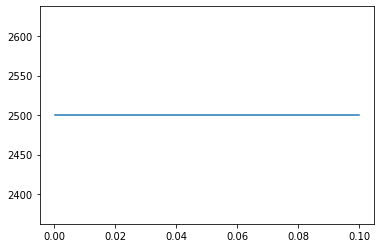

In [ ]:
# LEARNING_RATE_PROC = tune_lr(model=neural_network_model_proc, train_data=df_train_proc, val_data=df_val_proc, n_epochs=5)
LEARNING_RATE_PROC = tune_lr(model=neural_network_model_proc, train_data=df_val_proc, val_data=df_val_proc, n_epochs=1)

(Using raw data)

In [ ]:
LEARNING_RATE_RAW = tune_lr(model=neural_network_model_raw, train_data=df_train_raw, val_data=df_val_raw, n_epochs=5)

#### Tuning the number of epochs will take place during the actual training

### Training the model using the training data

In [ ]:
def train(model, train_data, val_data, learning_rate, n_epochs, model_path):

    loss_function = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()
        loss_function = loss_function.cuda()

    print('\n------------------------------------')
    print('Accelerator Name: ' + str(device))
    print('Learning Rate   : ' + str(learning_rate))
    print('No. of Epochs   : ' + str(n_epochs))
    print('------------------------------------', flush=True)

    train, val = Dataset(train_data), Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    epoch_scores = []
    best_accuracy = 0

    for epoch_num in range( 1, n_epochs + 1 ):

        total_accuracy = 0

        for train_input, train_label in tqdm(iterable=train_dataloader, desc='Epoch #' + str(epoch_num)):
            
            # Forward Propagation
            output, label = propagate_forwards(model=model, input=train_input, label=train_label, device=device)
            batch_loss = loss_function(output, label.float())

            # Backward Propagation
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        with torch.no_grad():
            
            for val_input, val_label in tqdm(iterable=val_dataloader, desc='Assessing'):

                # Forward Propagation
                output, label = propagate_forwards(model=model, input=val_input, label=val_label, device=device)
                batch_loss = loss_function(output, label.float())
                
                acc = (output.argmax(dim=1) == label).sum().item()
                total_accuracy += acc

        print(f'\nTraining epoch complete. | Validation accuracy = {total_accuracy / len(val_data): .3f}')
        if total_accuracy > best_accuracy:
            best_accuracy = total_accuracy
            print('Saving model checkpoint to disk...')
            torch.save( model.state_dict(), model_path )
        epoch_scores.append( total_accuracy )

    print('All done :)')

    plt.plot( range(1, n_epochs + 1), epoch_scores )
    plt.show()

### Evaluating the model using the test data

In [ ]:
def evaluate(model, test_data):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    
    predicted_labels, actual_labels = [], []

    with torch.no_grad():
        for test_input, test_label in tqdm(iterable=test_dataloader, desc='Evaluating'):

            output = propagate_forwards( model=model, input=test_input, label=test_label, device=device )

            predicted_labels.append( output.argmax(dim=1) )
            actual_labels.append( test_label )

    
    print(classification_report(actual_labels, predicted_labels, target_names=['-', '+']))
    ConfusionMatrixDisplay(confusion_matrix(actual_labels, predicted_labels), display_labels=['g', 'h']).plot()
    plt.show()

## Now we witness the magic :)

At this point, we've tuned all our hyperparameters and are ready to test the model for real

### Training the model using pre-processed data

In [ ]:
N_EPOCHS = 10
lr = LEARNING_RATE_PROC
print('\nTraining using pre-processed data', flush=True)
train(model=neural_network_model_proc, train_data=df_train_proc, val_data=df_val_proc, learning_rate=lr, n_epochs=N_EPOCHS, model_path='model_proc.pt')

### Training the model using raw data

In [ ]:
lr = LEARNING_RATE_RAW
print('Training using raw data', flush=True)
train(model=neural_network_model_raw, train_data=df_train_raw, val_data=df_val_raw, learning_rate=lr, n_epochs=N_EPOCHS, model_path='model_raw.pt')

### Evaluating the model

#### [OPTIONAL] Leading our pre-trained models from disk

Load model trained on pre-processed data

In [ ]:
### OPTIONAL ###
# Loads the model state dictionary from disk.
# Run this cell if the trained model is not in main memory (has not been trained in the same runtime)
neural_network_model_proc = NeuralNetwork( dropout_probability=0.5 )
neural_network_model_proc.load_state_dict( torch.load("model_proc.pt") )
neural_network_model_proc.eval()

Load model trained on raw data

In [ ]:
### OPTIONAL ###
# Loads the model state dictionary from disk.
# Run this cell if the trained model is not in main memory (has not been trained in the same runtime)
neural_network_model_raw = NeuralNetwork( dropout_probability=0.5 )
neural_network_model_raw.load_state_dict( torch.load("model_raw.pt") )
neural_network_model_raw.eval()

#### Evaluate the model
The moment of truth! :D

Model evaluation using pre-processed data

In [ ]:
evaluate( model=neural_network_model_proc, test_data=df_test_proc )

Model evaluation using raw data

In [ ]:
evaluate( model=neural_network_model_raw, test_data=df_test_raw )